<a href="https://colab.research.google.com/github/mella30/Deep-Learning-with-Tensorflow-2/blob/main/Course3-Probabilistic_Deep_Learning_with_Tensorflow2/week3_Scale_bijectors_and_LinearOperator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scale bijectors and LinearOperator

This reading is an introduction to scale bijectors, as well as the `LinearOperator` class, which can be used with them.

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
print("TF version:", tf.__version__)
print("TFP version:", tfp.__version__)

from IPython.display import Image

TF version: 2.6.0
TFP version: 0.13.0


## Introduction

You have now seen how bijectors can be used to transform tensors and tensor spaces. Until now, you've only seen this in the scalar case, where the bijector acts on a single value. When the tensors you fed into the bijectors had multiple components, the bijector acted on each component individually by applying batch operations to scalar values. For probability distributions, this corresponds to a scalar event space.

However, bijectors can also act on higher-dimensional space. You've seen, for example, the multivariate normal distribution, for which samples are tensors with more than one component. You'll need higher-dimensional bijectors to work with such distributions. In this reading, you'll see how bijectors can be used to generalise scale transformations to higher dimensions. You'll also see the `LinearOperator` class, which you can use to construct highly general scale bijectors. In this reading, you'll walk through the code, and we'll use figure examples to demonstrate these transformations.

This reading contains many images, as this allows you to visualise how a space is transformed. For this reason, the examples are limited to two dimensions, since these allow easy plots. However, these ideas generalise naturally to higher dimensions. Let's start by creating a point that is randomly distributed across the unit square $[0, 1] \times [0, 1]$:

In [2]:
# Create the base distribution and a single sample

uniform = tfd.Uniform(low=[0.0, 0.0], high=[1.0, 1.0], name='uniform2d')
x = uniform.sample()
x

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.63887024, 0.8947649 ], dtype=float32)>

We will be applying linear transformations to this data. To get a feel for how these transformations work, we show ten example sample points, and plot them, as well as the domain of the underlying distribution:

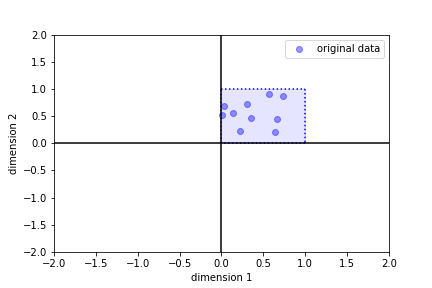

In [ ]:
# Run this cell to download and view a figure to show example data points

!wget -q -O x.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1DLqzh7xcjM7BS3C_QmgeF1xET2sXgMG0"
Image("x.png", width=500)


![](figures/x.png)

Each of the ten points is hence represented by a two-dimensional vector. Let $\mathbf{x} = [x_1, x_2]^T$ be one of these points. Then scale bijectors are linear transformations of $\mathbf{x}$, which can be represented by a $2 \times 2$ matrix $B$. The forward bijection to $\mathbf{y} = [y_1, y_2]^T$ is

$$
\mathbf{y} 
= 
\begin{bmatrix}
y_1 \\ y_2
\end{bmatrix}
= B \mathbf{x}
= \begin{bmatrix}
b_{11} & b_{12} \\
b_{21} & b_{22} \\
\end{bmatrix}
\begin{bmatrix}
x_1 \\ x_2
\end{bmatrix}
$$

This is important to remember: any two-dimensional scale bijector can be represented by a $2 \times 2$ matrix. For this reason, we'll sometimes use the term "matrix" to refer to the bijector itself. You'll be seeing how these points and domain are transformed under different bijectors  in two dimensions.

## The `ScaleMatvec` bijectors

### The `ScaleMatvecDiag` bijector

We'll start with a simple scale bijector created using the `ScaleMatvecDiag` class:

In [3]:
# Create the ScaleMatvecDiag bijector

bijector = tfb.ScaleMatvecDiag(scale_diag=[1.5, -0.5])

which creates a bijector represented by the diagonal matrix
$$ B = 
\begin{bmatrix}
1.5 & 0 \\
0 & -0.5 \\
\end{bmatrix}.
$$

We can apply this to the data using `y = bijector(x)` for each of the ten points. This transforms the data as follows:

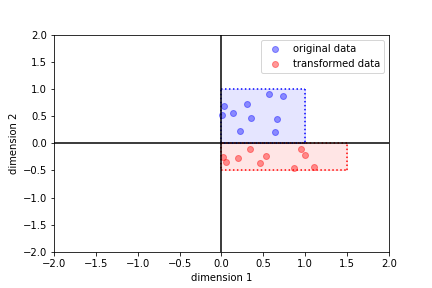

In [ ]:
# Run this cell to download and view a figure to illustrate the transformation

!wget -q -O diag.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1sgfZ_Qzdd2v7CErP2zIk04p6R6hUW7RR"
Image("diag.png", width=500)

You can see what happened here: the first coordinate is multiplied by 1.5 while the second is multipled by -0.5, flipping it through the horizontal axis.

In [4]:
# Apply the bijector to the sample point

y = bijector(x)
y

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 0.95830536, -0.44738245], dtype=float32)>

### The `ScaleMatvecTriL` bijector

In the previous example, the bijector matrix was diagonal, which essentially performs an independent scale operation on each of the two dimensions. The domain under the bijection remains rectangular. However, not all scale tarnsformations have to be like this. With a non-diagonal matrix, the domain will transform to a quadrilateral. One way to do this is by using the `tfb.ScaleMatvecTriL` class, which implements a bijection based on a lower-triangular matrix. For example, to implement the lower-triangular matrix
$$ B = 
\begin{bmatrix}
-1 & 0 \\
-1 & -1 \\
\end{bmatrix}
$$
you can use the `tfb.ScaleMatvecTriL` bijector as follows:

In [5]:
# Create the ScaleMatvecTriL bijector

bijector = tfb.ScaleMatvecTriL(scale_tril=[[-1., 0.],
                                           [-1., -1.]])

In [6]:
# Apply the bijector to the sample x

y = bijector(x)
y

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.63887024, -1.5336351 ], dtype=float32)>

A graphical overview of this change is:

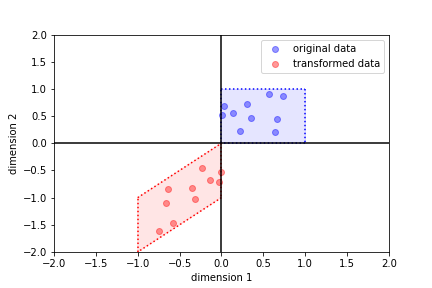

In [ ]:
# Run this cell to download and view a figure to illustrate the transformation

!wget -q -O lower_triangular.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1eMYwPzMVpmt1FYscplu7RRn1S4gmFo5B"
Image("lower_triangular.png", width=500)

## Inverse and composition

Scale transformations always map the point $[0, 0]$ to itself and are only one particular class of bijectors. As you saw before, you can create more complicated bijections by composing one with another. This works just like you would expect. For example, you can compose a scale transformation with a shift to the left (by one unit) as follows:

In [7]:
# Create a scale and shift bijector

scale_bijector = tfb.ScaleMatvecTriL(scale_tril=[[-1., 0.],
                                                 [-1., -1.]])
shift_bijector = tfb.Shift([-1., 0.])
bijector = shift_bijector(scale_bijector)

In [8]:
# Apply the bijector to the sample x

y = bijector(x)
y

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-1.6388702, -1.5336351], dtype=float32)>

which has the expected result:


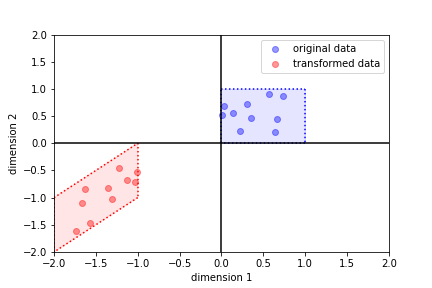

In [ ]:
# Run this cell to download and view a figure to illustrate the transformation

!wget -q -O scale_and_shift.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1iucwJlG2ropvJOkRfBMgEpuFNpYa_JH6"
Image("scale_and_shift.png", width=500)

Furthermore, bijectors are always invertible (with just a few special cases, see e.g. [`Absolute Value`](https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/AbsoluteValue)), and these scale transformations are no exception. For example, running

In [9]:
# Apply the inverse transformation to the image of x

bijector = tfb.ScaleMatvecTriL(scale_tril=[[-1., 0.],
                                           [-1., -1.]])
y = bijector.inverse(bijector(x))

recovers `x`:

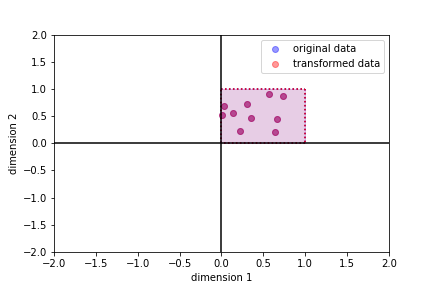

In [10]:
# Run this cell to download and view a figure to illustrate the transformation

!wget -q -O inverse.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1CHCkSfz6EnOYiZaw6vGZ_s6BzyP1NK1X"
Image("inverse.png", width=500)

so that the original and transformed data is the same.

In [11]:
# Check that all y and x values are the same

tf.reduce_all(y == x)

<tf.Tensor: shape=(), dtype=bool, numpy=True>

## The `LinearOperator` class and `ScaleMatvecLinearOperator` bijector

The examples you just saw used the `ScaleMatvecDiag` and `ScaleMatvecTriL` bijectors, whose transformations can be represented by diagonal and lower-triangular matrices respectively. These are convenient since it's easy to check whether such matrices are invertible (a requirement for a bijector). However, this comes at a cost of generality: there are acceptable bijectors whose matrices are not diagonal or lower-triangular. To construct these more general bijectors, you can use the `ScaleMatvecLinearOperator` class, which operates on instances of `tf.linalg.LinearOperator`.

The `LinearOperator` is a class that allows the creation and manipulation of linear operators in TensorFlow. It's rare to call the class directly, but its subclasses represent many of the common linear operators. It's programmed in a way to have computational advantages when working with big linear operators, although we won't discuss these here. What matters now is that we can use these linear operators to define bijectors using the `ScaleMatvecLinearOperator` class. Let's see how this works.

### The `LinearOperatorDiag` class

First, let's use this framework to recreate our first bijector, represented by the diagonal matrix

$$ B = 
\begin{bmatrix}
1.5 & 0 \\
0 & -0.5 \\
\end{bmatrix}.
$$

You can do this using the `ScaleMatvecLinearOperator` as follows. First, we'll create the linear operator that represents the scale transformation using 

In [12]:
scale = tf.linalg.LinearOperatorDiag(diag=[1.5, -0.5])

where `LinearOperatorDiag` is one of the subclasses of `LinearOperator`. As the name suggests, it implements a diagonal matrix. We then use this to create the bijector using the `tfb.ScaleMatvecLinearOperator`:

In [13]:
# Create the ScaleMatvecLinearOperator bijector

bijector = tfb.ScaleMatvecLinearOperator(scale)

This bijector is the same as the first one above:

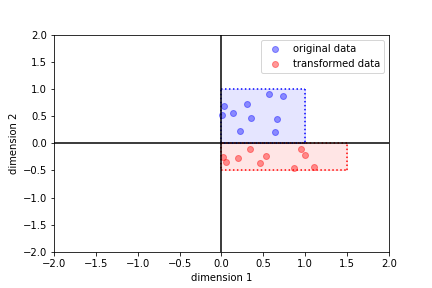

In [ ]:
# Run this cell to download and view a figure to illustrate the transformation

!wget -q -O linear_operator_diag.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1KaCJl28Thp6NjxspG3pq251vDJrmDd97"
Image("linear_operator_diag.png", width=500)

In [14]:
# Apply the bijector to the sample x

y = bijector(x)
y

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 0.95830536, -0.44738245], dtype=float32)>

### The `LinearOperatorFullMatrix` class

We can also use this framework to create a bijector represented by a custom matrix. Suppose we have the matrix

$$ B = 
\begin{bmatrix}
0.5 & 1.5 \\
1.5 & 0.5 \\
\end{bmatrix}
$$

which is neither diagonal nor lower-triangular. We can implement a bijector for it using the `ScaleMatvecLinearOperator` class by using another subclass of `LinearOperator`, namely the `LinearOperatorFullMatrix`, as follows:

In [15]:
# Create a ScaleMatvecLinearOperator bijector

B = [[0.5, 1.5],
     [1.5, 0.5]]
scale = tf.linalg.LinearOperatorFullMatrix(matrix=B)
bijector = tfb.ScaleMatvecLinearOperator(scale)

which leads to the following transformation:

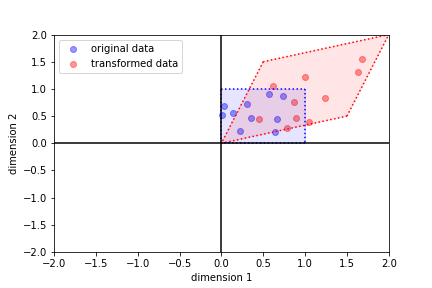

In [ ]:
# Run this cell to download and view a figure to illustrate the transformation

!wget -q -O linear_operator_full.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1Zk5lp7-VTwmX5r0yPAqVGGzWIgYTjJIJ"
Image("linear_operator_full.png", width=500)

In [16]:
# Apply the bijector to the sample x

y = bijector(x)
y

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.6615825, 1.4056878], dtype=float32)>

### Batch operations and broadcasting

As you've seen before, it's important to be very careful with shapes in TensorFlow Probability. That's because there are three possible components to a shape: the event shape (dimensionality of the random variable), sample shape (dimensionality of the samples drawn) and batch shape (multiple distributions can be considered in one object). This subtlety is especially important for bijectors, but can be harnassed to make powerful, and very computationally efficient, transformations of spaces. Let's examine this a little bit in this section.

In the previous examples, we applied a bijector to a two-dimensional data point $\mathbf{x}$ to create a two-dimensional data point $\mathbf{y}$. This was done using $\mathbf{y} = B \mathbf{x}$ where $B$ is the $2 \times 2$ matrix that represents the scale bijector. This is simply matrix multiplication. To implement this, we created a tensor `x` with `x.shape == [2]` and a bijector using a matrix of shape `B.shape == [2, 2]`. This generalises straightforwardly to higher dimensions: if $\mathbf{x}$ is $n$-dimensional, the bijection matrix must be of shape $n \times n$ for some $n>0$. In this case, $\mathbf{y}$ is $n$-dimensional.

But what if you wanted to apply the same bijection to ten $\mathbf{x}$ values at once? You can then arrange all these samples into a single tensor `x` with `x.shape == [10, 2]` and create a bijector as usual, with a matrix of shape `B.shape == [2, 2]`.

In [17]:
# Create 10 samples from the uniform distribution

x = uniform.sample(10)
x

<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[0.13592064, 0.3409475 ],
       [0.413566  , 0.17970681],
       [0.4879141 , 0.5509242 ],
       [0.89257765, 0.9590199 ],
       [0.93187475, 0.09982574],
       [0.3535365 , 0.8222735 ],
       [0.20840204, 0.80321145],
       [0.64834464, 0.41095316],
       [0.5187179 , 0.21837819],
       [0.7850386 , 0.7118113 ]], dtype=float32)>

In [18]:
# Recreate the diagonal matrix transformation with LinearOperatorDiag

scale = tf.linalg.LinearOperatorDiag(diag=[1.5, -0.5])
scale.to_dense()

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 1.5,  0. ],
       [ 0. , -0.5]], dtype=float32)>

In [19]:
# Create the ScaleMatvecLinearOperator bijector

bijector = tfb.ScaleMatvecLinearOperator(scale)

In [20]:
# Apply the bijector to the 10 samples

y = bijector(x)
y

<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[ 0.20388097, -0.17047375],
       [ 0.620349  , -0.08985341],
       [ 0.7318711 , -0.2754621 ],
       [ 1.3388665 , -0.47950995],
       [ 1.3978121 , -0.04991287],
       [ 0.53030473, -0.41113675],
       [ 0.31260306, -0.40160573],
       [ 0.97251695, -0.20547658],
       [ 0.7780768 , -0.10918909],
       [ 1.177558  , -0.35590565]], dtype=float32)>

This gives us the same plot we had before:

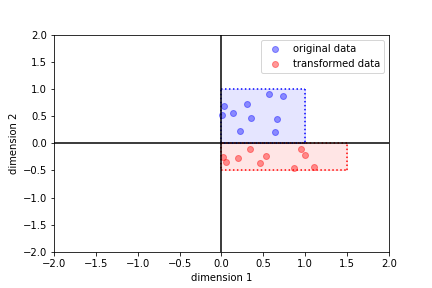

In [ ]:
# Run this cell to download and view a figure to illustrate the transformation

!wget -q -O diag.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1sgfZ_Qzdd2v7CErP2zIk04p6R6hUW7RR"
Image("diag.png", width=500)

For matrix multiplication to work, we need `B.shape[-1] == x.shape[-1]`, and the output tensor has last dimension `y.shape[-1] == B.shape[-2]`. For invertibility, we also need the matrix `B` to be square. Any dimensions except for the last one on `x` become sample/batch dimensions: the operation is broadcast across these dimensions as we are used to. It's probably easiest to understand through a table of values, where `s`, `b`, `m`, and `n` are positive integers and `m != n`:

| `B.shape` | `x.shape` | `y.shape` |
| ----- | ----- | ----- | 
| `(2, 2)` | `(2)` | `(2)` |
| `(n, n)` | `(m)` | `ERROR` | 
| `(n, n)` | `(n)` | `(n)` | 
| `(n, n)` | `(s, n)` | `(s, n)` | 
| `(b, n, n)` | `(n)` | `(b, n)` |
| `(b, n, n)` | `(b, n)` | `(b, n)` |
| `(b, n, n)` | `(s, 1, n)` | `(s, b, n)` |  

These rules and the ability to broadcast make batch operations easy. 

We can also easily apply multiple bijectors. Suppose we want to apply both these bijectors:

$$
\begin{align}
B_1 = 
\begin{bmatrix}
1 & 0 \\
0 & -1 \\
\end{bmatrix}
& \qquad
B_2 = 
\begin{bmatrix}
-1 & 0 \\
0 & 1 \\
\end{bmatrix}.
\end{align}
$$

We can do this using the batched bijector

In [21]:
# Create a batched ScaleMatvecLinearOperator bijector

diag = tf.stack((tf.constant([1, -1.]), 
                 tf.constant([-1, 1.])))  # (2, 2)
scale = tf.linalg.LinearOperatorDiag(diag=diag)  # (2, 2, 2)
bijector = tfb.ScaleMatvecLinearOperator(scale=scale)

and we can broadcast the samples across both bijectors in the batch, as well as broadcasting the bijectors across all samples. For this, we need to include a batch dimension in the samples Tensor.

In [22]:
# Add a singleton batch dimension to x

x = tf.expand_dims(x, axis=1)
x.shape

TensorShape([10, 1, 2])

In [23]:
# Apply the batched bijector to x

y = bijector(x)
y.shape  # (S, B, E) shape semantics

TensorShape([10, 2, 2])

which gives two batches of forward values for each sample:

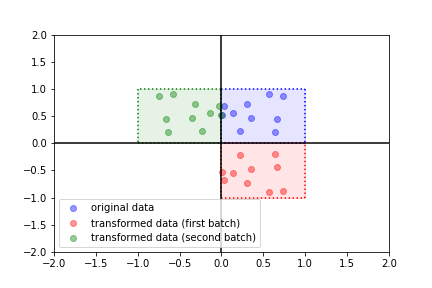

In [ ]:
# Run this cell to download and view a figure to illustrate the transformation

!wget -q -O linear_operator_batch.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1obgl3sOIYsH_ijxxkhgBu4miBxq23fny"
Image("linear_operator_batch.png", width=500)

## Conclusion

In this reading, you saw how to construct scale bijectors in two dimensions using the various `ScaleMatvec` classes. You also had a quick introduction to the general `LinearOperators` class and some of its subclasses. Finally, you saw how batching makes large computations clean and efficient. Be careful to keep track of the tensor shapes, as broadcasting and the difference between batch shapes and event shapes makes errors easy. Finally, note that these bijectors are still amenable to composition (via `Chain` or simply feeding one into another) and inversion, which retains the same syntax you're used to. Enjoy using this powerful tool!

### Further reading and resources

* `ScaleMatvec` bijectors:
  * https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/ScaleMatvecDiag\n",
  * https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/ScaleMatvecLinearOperator\n",
  * https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/ScaleMatvecLU\n",
  * https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/ScaleMatvecTriL\n",
* `LinearOperator` class (see also subclasses)
  * https://www.tensorflow.org/api_docs/python/tf/linalg/LinearOperator